# About this Notebook

Within this notebook, log data from an online plattform is used to evaluate a new feature. The plattform can be used to book appointments in different locations (like barbers). With the new feature, users can see which venues are top-ranked. The data ranges from 01/09/2017 until 14/11/2017. The new feature was introduced on the 4th of October 2017.

Two **tables** are available:
* Venues: List of venues with information about whether they are top-ranked or not
* Events: Log data from user visits

The following **questions** should be answered:

*Business-Perspective*:
* Does the new feature increase the probability that a booking process is completed?

*Regarding the user experience*:
* Does the new feature help to decrease the search time?
* Do users find the recommendations useful? &rarr; Does the number of bookings increase if a venue is top-rated?

The following **assumptions** are made:
* There is no substantial change in the user behaviour across the months September to November (otherwise the data from the two groups must have been collected at the same time)

First, the two tables are loaded:

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

# read data
events_df = pd.read_csv("GB_events.csv")
venues_df = pd.read_csv("ldn_venues.csv")

# Data Exploration
Taking a first quick look at the events-table.

There are almost 3 milion log-events from 91.957 sessions.
Within one session, there can be multiple bookings (every event with the page-type-category *Confirmed* is considered as a new booking if the previous page-type-category was different). Therefore it won't make sense to measure the conversion rate using the sessions, instead the number of successfull bookings shall be used.

# events: 2968899

# sessions: 91957

Index(['Unnamed: 0', 'X', 'session_id', 'collector_time', 'event',
       'filtered_top_rated', 'page_type_category', 'venue_id'],
      dtype='object')
                             session_id  confirmation_counts
1720   178d9bce60af484258b14f17937d85a4                   14
5247   45b279428c6ab3c088cc3f65711dd7e5                   14
15564  cf41e88ff397313428ebb23e47b16d08                   13


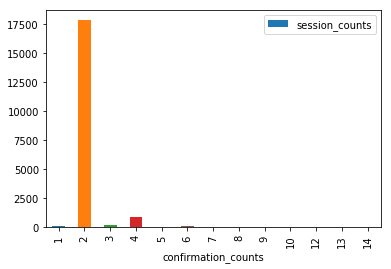

In [2]:
print("# events: %s" % len(events_df) + "\n")
print("# sessions: %s" % len(events_df.groupby("session_id").count()) + "\n")
print(events_df.columns)

# are there multiple bookings/confirmations per session?
conf_df = events_df[(events_df['page_type_category'] == 'Confirmed') & (events_df['event'] == 'page_view')][['page_type_category', 'session_id']] \
    .groupby("session_id", as_index=False) \
    .count() \
    .rename(columns={'page_type_category': 'confirmation_counts'})
print(conf_df.sort_values('confirmation_counts', ascending=False).head(3))
    
conf_df = conf_df.groupby("confirmation_counts", as_index=False).count().rename(columns={'session_id': 'session_counts'})

conf_df.plot.bar(x='confirmation_counts', y='session_counts')

# Data Preparation
In order to check whether the conversion rate increased with the new feature, a booking table has to be generated.

In this notebook, a booking is defined as the cycle from the session start to the first confirmation-event. If there is no confirmation (user did not book), the booking ends with the session end. If there are multiple bookings within a session, the a booking ends with the confirmation and the next booking starts with the next event. 

First, I will check for missing values and do some transformations on the data.
## Transformations

In [3]:
events_df['filtered_top_rated'] = (events_df['filtered_top_rated'] == 'y')

# replace top_rated_info by boolean field
venues_df['top_rated'] = (venues_df['top_rated_info'] == True)
venues_df2 = venues_df.drop('top_rated_info', axis=1)

## Check missing values
In the event-table, the only the venue-id has missing values since this data is only recorded for a few steps in the order process. The missing values will be filled once the booking table is ready.

In the venue table, only the churn_data-column has missing values (if the venue did not leave the platform, there is no data in the table). This will be ignored since the feature will not be used in the next steps.

In [4]:
events_cnt = len(events_df)
for column in events_df.columns:
    print(column + ": " + str(len(events_df.dropna(axis=0, subset=[column]))/events_cnt *100) + "%")
print("")

venues_cnt = len(venues_df2)
for column in venues_df2.columns:
    print(column + ": " + str(len(venues_df2.dropna(axis=0, subset=[column]))/venues_cnt *100) + "%")


Unnamed: 0: 100.0%
X: 100.0%
session_id: 100.0%
collector_time: 100.0%
event: 100.0%
filtered_top_rated: 100.0%
page_type_category: 100.0%
venue_id: 49.13336560118751%

Unnamed: 0: 100.0%
venue_id: 100.0%
purchasable_date: 100.0%
churn_date: 13.64562118126273%
top_rated: 100.0%


## Create bookingcycle-table
The data is ready to create the booking table.

A new cycle starts with a new session or after a previous booking within the same session and ends when a user reaches the confirmation page or when the session ends.

The table will have the follwing schema:
- ID: sessionid + starttime
- Starttime
- Endtime
- Successful (ended with confirmation) [bool]
- ratings available [bool]
- Time to confirmation in seconds [int]
- Time to last time-selection in seconds [int] -> search time

To find the starts and ends of a cycle, each potential start (session start or event after confirmation) and end (session end or confirmation) will be labeled accordingly.

In [5]:
# add some additional columns as preparation for the labeling
session_ids = set(events_df['session_id'])
booking_cycles = pd.DataFrame()
session_starts = events_df.groupby('session_id')['X'].min()
session_ends = events_df.groupby('session_id')['X'].max()

events_df['prev_page_type'] = events_df.groupby('session_id')['page_type_category'].shift(1)
events_df['next_page_type'] = events_df.groupby('session_id')['page_type_category'].shift(-1)


def label_event(category, prev_category, next_category):
    """
    Labels an event as start or end of a booking cycle if applicable.
    """
    if(category == 'Confirmed'):
        return 'confirmation_end'
    elif((prev_category == 'Confirmed') & (category != 'Confirmed')):
        return 'booking_start'
    elif(pd.isna(prev_category)):
        return 'booking_start'
    elif(pd.isna(next_category)):
        return 'booking_end'
    else:
        return ""

# label every event
events_df['label'] = events_df \
    .apply(lambda x: label_event(x['page_type_category'], x['prev_page_type'], x['next_page_type']), axis=1)

The cycles are created by taking every start-event together with their next end-event. After that, some additional columns are added:
* Start_time: Time of the start-event
* End_time: Time of the end-event
* Start_ID: Id of the start-event
* Cycle_time_seconds: Seconds between start and end time
* Cycle_ID: String created by concatenating session_id and start time
* Confirmed: True if the cycle ended with a confirmation
* Feature_available: Indicates whether the new feature is available or not (true for every cycle that starts after midnight on the 4th of October 2017)

In [6]:
# create booking cycle table
booking_events = events_df[events_df['label'] != ""] 
booking_events[['end_id', 'next_time', 'next_label']] = \
    booking_events.groupby('session_id')[['X', 'collector_time', 'label']].shift(-1)

booking_cycles = booking_events[(booking_events['label'] == 'booking_start') & \
                                ((booking_events['next_label'] == 'booking_end') | \
                                 (booking_events['next_label'] == 'confirmation_end'))]

booking_cycles['start_time'] = pd.to_datetime(booking_cycles['collector_time'])
booking_cycles['end_time'] = pd.to_datetime(booking_cycles['next_time'])
booking_cycles['start_id'] = booking_cycles['X']
booking_cycles['cycle_time_seconds'] = (booking_cycles['end_time'] - booking_cycles['start_time']).dt.total_seconds()
booking_cycles['confirmed'] = booking_cycles['next_label'] == 'confirmation_end'
booking_cycles['cycle_id'] = booking_cycles['session_id'] + str(booking_cycles['start_time'])

# add column that indicates whether the new top rated-feature was available
booking_cycles['feature_available'] = booking_cycles['start_time'] >= "2017-10-04 00:00:00"

# remove redundant columns
booking_cycles = booking_cycles[['cycle_id', 'session_id', 'start_time', 'end_time', 'cycle_time_seconds', \
                                 'confirmed', 'feature_available', 'start_id', 'end_id']]

In [7]:
# testing the results on a session with multiple bookings
assert(len(booking_cycles[booking_cycles['cycle_time_seconds'] < 0]) == 0)
print((booking_cycles[booking_cycles['session_id'] == '72d226e3488091bbcc5381466400dc0b']\
       [['start_time', 'end_time', 'start_id', 'end_id', 'confirmed']]))
print("")
for i, row in (events_df[(events_df['session_id'] == '72d226e3488091bbcc5381466400dc0b')]\
      [['collector_time', 'X', 'page_type_category']]).iterrows():
    print(row[['page_type_category', 'collector_time', 'X']])

                 start_time            end_time  start_id     end_id  \
1956215 2017-10-14 15:18:11 2017-10-14 15:29:20   1956216  1956279.0   
1956280 2017-10-14 15:29:40 2017-10-14 15:35:37   1956281  1956331.0   
1956331 2017-10-14 15:35:44 2017-10-14 16:24:41   1956332  1956660.0   
1956661 2017-10-14 16:25:05 2017-10-14 16:45:18   1956662  1956786.0   
1956787 2017-10-14 16:45:31 2017-10-14 16:57:01   1956788  1956846.0   
1956847 2017-10-14 16:57:13 2017-10-14 17:02:22   1956848  1956854.0   

         confirmed  
1956215       True  
1956280       True  
1956331       True  
1956661       True  
1956787       True  
1956847      False  

page_type_category               Homepage
collector_time        2017-10-14 15:18:11
X                                 1956216
Name: 1956215, dtype: object
page_type_category               Homepage
collector_time        2017-10-14 15:19:24
X                                 1956217
Name: 1956216, dtype: object
page_type_category               Home

Name: 1956344, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 15:39:52
X                                 1956346
Name: 1956345, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 15:39:54
X                                 1956347
Name: 1956346, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 15:39:55
X                                 1956348
Name: 1956347, dtype: object
page_type_category    Time-selection Page
collector_time        2017-10-14 15:40:08
X                                 1956349
Name: 1956348, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 15:40:08
X                                 1956350
Name: 1956349, dtype: object
page_type_category               Checkout
collector_time        2017-10-14 15:40:40
X                                 1956351
Name: 1956350, dtype: object
page_type_category    Time-selection Page

Name: 1956477, dtype: object
page_type_category               Homepage
collector_time        2017-10-14 15:55:38
X                                 1956479
Name: 1956478, dtype: object
page_type_category               Homepage
collector_time        2017-10-14 15:55:47
X                                 1956480
Name: 1956479, dtype: object
page_type_category               Homepage
collector_time        2017-10-14 15:55:49
X                                 1956481
Name: 1956480, dtype: object
page_type_category               Homepage
collector_time        2017-10-14 15:55:54
X                                 1956482
Name: 1956481, dtype: object
page_type_category               Homepage
collector_time        2017-10-14 15:56:01
X                                 1956483
Name: 1956482, dtype: object
page_type_category            Browse Page
collector_time        2017-10-14 15:56:02
X                                 1956484
Name: 1956483, dtype: object
page_type_category            Browse Page

Name: 1956635, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:21:28
X                                 1956637
Name: 1956636, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:21:34
X                                 1956638
Name: 1956637, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:21:35
X                                 1956639
Name: 1956638, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:21:54
X                                 1956640
Name: 1956639, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:21:54
X                                 1956641
Name: 1956640, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:22:47
X                                 1956642
Name: 1956641, dtype: object
page_type_category             Venue Page

Name: 1956799, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:47:00
X                                 1956801
Name: 1956800, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:47:24
X                                 1956802
Name: 1956801, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:47:30
X                                 1956803
Name: 1956802, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:47:30
X                                 1956804
Name: 1956803, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:47:41
X                                 1956805
Name: 1956804, dtype: object
page_type_category             Venue Page
collector_time        2017-10-14 16:47:41
X                                 1956806
Name: 1956805, dtype: object
page_type_category             Venue Page

### Additional features:
* last_venue_viewed: Which venue did the user choose if he placed an order?
* venue_top_rated: Was the venue among the higher ranked venues?
* search_time

In [8]:
# for every booking that ended with a confirmation, get the latest time-selection event
time_selection_df = events_df[events_df['page_type_category'] == 'Time-selection Page']\
    [['X', 'page_type_category', 'session_id', 'venue_id', 'collector_time']]
bookings_with_times = booking_cycles.merge(time_selection_df, on='session_id', how='left')

def check_time(idx, start_idx, end_idx):
    if pd.isna(idx):
        return None
    elif((end_idx >= idx) & (start_idx <= idx)):
        return idx
    else:
        return None
    
# bookings_with_times['relevant_time'] = (bookings_with_times['end_id'] >= bookings_with_times['X']) & \
#                                        (bookings_with_times['start_id'] <= bookings_with_times['X']) 
bookings_with_times['X'] = bookings_with_times.apply(lambda x: check_time(x['X'], x['end_id'], x['start_id']), axis=1)

bookings_with_times = bookings_with_times.groupby(list(booking_cycles.columns), as_index=False).max() 

# extract venue id of the latest venue viewed
bookings_with_venues = bookings_with_times.merge(time_selection_df, on='X', how='left')\
                        [['cycle_id', 'session_id_x', 'start_time', 'end_time', \
                        'cycle_time_seconds', 'confirmed', 'feature_available', \
                        'start_id', 'end_id', 'venue_id_y', 'collector_time_y']] \
                        .rename(columns={'venue_id_y': 'venue_id', 'session_id_x': 'session_id', \
                                         'collector_time_y': 'time_selector_time'})

# add column that shows whether the viewed venue is top rated
bookings_with_venues = bookings_with_venues.merge(venues_df[['venue_id', 'top_rated']], on='venue_id', how='left')\
    .rename(columns={'venue_id': 'last_venue_viewed', 'top_rated': 'venue_top_rated'})

# add search time column (= time between start and last time selection)
bookings_with_venues['time_selector_time'] = pd.to_datetime(bookings_with_venues['time_selector_time'])
bookings_with_venues['search_time'] = (bookings_with_venues['time_selector_time'] - bookings_with_venues['start_time'])\
    .dt.total_seconds()
bookings_with_venues['search_time'] = bookings_with_venues\
    .apply(lambda x: x['search_time'] if pd.notna(x['search_time']) else x['cycle_time_seconds'], axis=1)
    
assert(len(bookings_with_venues) == len(booking_cycles))
assert(len(bookings_with_venues[bookings_with_venues['search_time'] < 0]) == 0)

bookings = bookings_with_venues

# Hypothesis Testing I
Question to be answered: *Does the new feature increase the probability of a completed booking?*

Metric: Number of completed bookings/Number of bookingcycles started

*H0: p_test - p_control >= 0* &rarr; difference between confirmation probability is equal or lower to zero.

*H1: p_test - p_control < 0* &rarr; difference between confirmation probability is greater than zero.

# Graphical Analysis


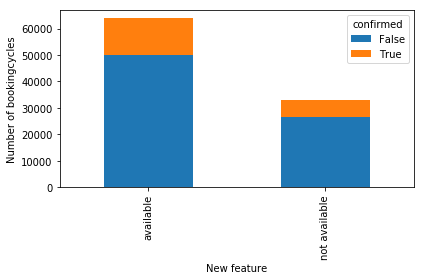

In [9]:
plot_cycles = booking_cycles
plot_cycles['confirmed_x'] = plot_cycles.apply(lambda x: 'confirmed' if x['confirmed'] else 'not confirmed', axis=1)
plot_cycles['new_feature'] = plot_cycles.apply(lambda x: 'available' if x['feature_available'] == True else 'not available', axis=1)
#df2 = plot_cycles.groupby(['confirmed', 'new_feature'])['confirmed'].count().unstack('new_feature').fillna(0)
#df2[['available', 'not available']].plot(kind='bar', stacked=True)
ax = plot_cycles.groupby(['new_feature', 'confirmed']).size().unstack().plot(kind='bar', stacked=True)
ax.set_xlabel('New feature')
ax.set_ylabel('Number of bookingcycles')
plt.tight_layout()

### Step 1 - Calculate confirmation probabilities

In [10]:
control_df = booking_cycles[booking_cycles['start_time'] < "2017-10-04 00:00:00"]
test_df = booking_cycles[booking_cycles['start_time'] >= "2017-10-04 00:00:00"]
conf_cntrl = control_df[control_df['confirmed'] == True]
conf_test = test_df[test_df['confirmed'] == True]
p_cntrl = len(conf_cntrl)/len(control_df)
p_test = len(conf_test)/len(test_df)
print("Probability for confirmation in control: " + str(p_cntrl))
print("Probability for confirmation in test: " + str(p_test) + "\n")

print("n_ctrl: " + str(len(control_df)))
print("n_test: " + str(len(test_df)))

Probability for confirmation in control: 0.1999094749547375
Probability for confirmation in test: 0.2184906842022859

n_ctrl: 33140
n_test: 63870


In [11]:
p_null = len(booking_cycles[booking_cycles['confirmed'] == True])/len(booking_cycles)
print("Probability if H0 true: " + str(p_null))
print("Differences in probability: " + str(p_test - p_cntrl))

Probability if H0 true: 0.21214307803319246
Differences in probability: 0.018581209247548414



### Step 2 - Check statistical significance

In [12]:
# z-value for 95% (one-sided) = 1.65.
z_value = 1.65

diff_e = p_test - p_cntrl

se_cntrl = control_df['confirmed'].sem()
se_test = test_df['confirmed'].sem()

# pooled standard error:
se_pool = (se_cntrl**2 + se_test**2)**(1/2)

# margin error:
margin_error = se_pool * z_value

# check significance. H0 can be rejected since estimated difference greater than margin error.
print(diff_e > margin_error)

True


# Hypothesis Testing II
Question to be answered: *Does the new feature decrease the search time?*

Metric: Search time per successfull booking

*H0: dur_test - dur_cntrl <= 0* &rarr; difference between search times is equal or lower to zero.

*H1: dur_test - dur_cntrl > 0* &rarr; difference between search times is greater than zero.

Only successfull bookings will be considered here.

## Graphical analysis
After removing the outliers, there seems to be a slight tendency that the new feature helped decreasing the mean search time. This must be confirmed using a Welch test.

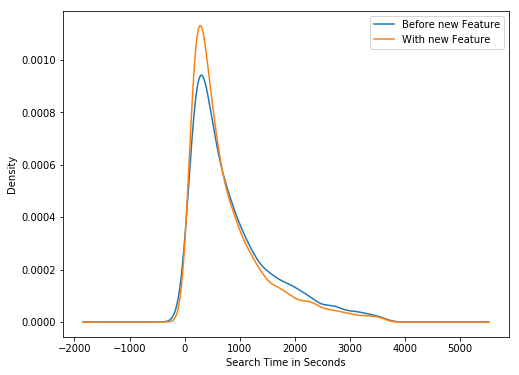

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
labels = list()
search_times = bookings[bookings['confirmed'] == True]
q = search_times['search_time'].quantile(0.98)
search_times = search_times[search_times['search_time'] < q]

for label, df in search_times[['feature_available', 'search_time']].groupby('feature_available'):
    if(label):
        l = "With new Feature"
    else:
        l = "Before new Feature" 
    df['search_time'].plot(kind="kde", ax=ax, label=l)
    
ax.set_xlabel('Search Time in Seconds')
plt.legend()

### Step 1 - Calculate duration distributions
Assumption: Search time is normally distributed.

In [13]:
success_bookings = bookings[bookings['confirmed'] == True]
control_df2 = success_bookings[success_bookings['start_time'] < "2017-10-04 00:00:00"]
test_df2 = success_bookings[success_bookings['start_time'] >= "2017-10-04 00:00:00"]
cntrl_mdur = control_df2['search_time'].mean()
test_mdur = test_df2['search_time'].mean()
print("Mean duration control: " + str(cntrl_mdur))
print("Mean duration test: " + str(test_mdur) + "\n")

print("n_ctrl: " + str(len(control_df)))
print("n_test: " + str(len(test_df)))

Mean duration control: 1605.187320754717
Mean duration test: 1149.617699749194

n_ctrl: 33140
n_test: 63870


### Step 2 - Check statistical significance
A one-sided Welch-test is used to check H0. I chose the Welch-test here since the test does not require equal variances within the populations.

The H0 (search time with new feature >= search time without new feature) can be rejected.

In [14]:
from scipy import stats

# perform Welch-test
t, p = stats.ttest_ind(test_df2['search_time'], control_df2['search_time'], equal_var=False)

# since this is the result of a two-sided test, p has to be divided by 2
p = p/2
print("t-statistics: " + str(t))
print("p-value: " + str(p))

print(p < 0.05)

t-statistics: -1.9722253688754985
p-value: 0.024298626801130086
True


In [17]:
"""add column that shows whether the user used the top-rated filter
top_rated_events = events_df[events_df['filtered_top_rated'] == True][['session_id', 'X']]
bookings_with_top_rated = bookings_with_venues.merge(top_rated_events, on='session_id', how='left')
bookings_with_top_rated['rated_time_ok'] = bookings_with_top_rated \
    .apply(lambda x: check_time(x['X'], x['start_id'], x['end_id']), axis=1)
bookings_with_top_rated = bookings_with_top_rated[pd.notna(bookings_with_top_rated['rated_time_ok'])] \
    .groupby('cycle_id', as_index=False).count()[['cycle_id', 'rated_time_ok']]
# print((bookings_with_top_rated.groupby('cycle_id', as_index=False)['rated_time_ok'].head(2)))

cols = list(bookings_with_venues.columns)
bookings = bookings_with_top_rated.merge(bookings_with_venues, on='cycle_id', how='right')
bookings['filtered_top_ratings'] = pd.notnull(bookings['rated_time_ok'])
new_cols = cols + ['filtered_top_ratings']
bookings = bookings[new_cols]

print(len(bookings))
print(len(bookings_with_venues))
assert(len(bookings) == len(bookings_with_venues))

print(len(bookings[(bookings['filtered_top_ratings'] == True) & \
                    (bookings['start_time'] < pd.to_datetime('2017-10-04 00:00:00'))]))

# test: filter use may only occure after release
assert(len(bookings[(bookings['filtered_top_ratings'] == True) & \
                    (bookings['start_time'] < pd.to_datetime('2017-10-04 00:00:00'))]) == 0)

print(len(bookings))
assert(len(bookings) == len(booking_cycles))"""

"add column that shows whether the user used the top-rated filter\ntop_rated_events = events_df[events_df['filtered_top_rated'] == True][['session_id', 'X']]\nbookings_with_top_rated = bookings_with_venues.merge(top_rated_events, on='session_id', how='left')\nbookings_with_top_rated['rated_time_ok'] = bookings_with_top_rated     .apply(lambda x: check_time(x['X'], x['start_id'], x['end_id']), axis=1)\nbookings_with_top_rated = bookings_with_top_rated[pd.notna(bookings_with_top_rated['rated_time_ok'])]     .groupby('cycle_id', as_index=False).count()[['cycle_id', 'rated_time_ok']]\n# print((bookings_with_top_rated.groupby('cycle_id', as_index=False)['rated_time_ok'].head(2)))\n\ncols = list(bookings_with_venues.columns)\nbookings = bookings_with_top_rated.merge(bookings_with_venues, on='cycle_id', how='right')\nbookings['filtered_top_ratings'] = pd.notnull(bookings['rated_time_ok'])\nnew_cols = cols + ['filtered_top_ratings']\nbookings = bookings[new_cols]\n\nprint(len(bookings))\nprint

In [18]:
print(bookings.columns)
print(len(bookings))
print(len(bookings[bookings['feature_available'] == True]))
print(len(bookings[bookings['feature_available'] == False]))

Index(['cycle_id', 'session_id', 'start_time', 'end_time',
       'cycle_time_seconds', 'confirmed', 'feature_available', 'start_id',
       'end_id', 'last_venue_viewed', 'time_selector_time', 'venue_top_rated',
       'search_time'],
      dtype='object')
97010
63870
33140
